In [6]:
import json
from pathlib import Path
import pandas as pd
import numpy as np
from tqdm import tqdm

from mplsoccer import Pitch, VerticalPitch





def load_competitions(sb_data_root: Path) -> pd.DataFrame:
    comp_path = sb_data_root / "competitions.json"
    comps = json.loads(comp_path.read_text(encoding="utf-8"))
    return pd.DataFrame(comps)

TARGET = [
    ("England", "Premier League"),
 #   ("Spain", "La Liga"),
  #  ("Italy", "Serie A"),
   # ("Germany", "1. Bundesliga"),
]

def pick_competitions_1516(comps):
    selected = []

    for country, comp in TARGET:
        sel = comps[
            (comps["country_name"] == country) &
            (comps["competition_name"] == comp) &
            (comps["season_name"] == "2015/2016")
        ]

        if sel.empty:
            raise ValueError(f"Missing: {country} {comp} 2015/2016")

        selected.append(sel.iloc[0])

    return pd.DataFrame(selected)


def load_matches(sb_data_root: Path, competition_id: int, season_id: int) -> pd.DataFrame:
    p = sb_data_root / "matches" / str(competition_id) / f"{season_id}.json"
    matches = json.loads(p.read_text(encoding="utf-8"))
    return pd.DataFrame(matches)

def _safe_id(x):
    if isinstance(x, dict) and "id" in x: return x["id"]
    return np.nan

def _safe_name(x):
    if isinstance(x, dict) and "name" in x: return x["name"]
    return None

def flatten_events_for_match(sb_data_root: Path, match_row: dict) -> pd.DataFrame:
    match_id = match_row["match_id"]
    p = sb_data_root / "events" / f"{match_id}.json"
    ev = json.loads(p.read_text(encoding="utf-8"))

    rows = []
    for e in ev:
        loc = e.get("location", None)
        x = loc[0] if isinstance(loc, list) and len(loc) >= 2 else np.nan
        y = loc[1] if isinstance(loc, list) and len(loc) >= 2 else np.nan

        # end locations (pass/carry)
        endx = endy = np.nan
        pass_length = np.nan
        pass_subtype = None

        if "pass" in e and e["pass"] is not None:
            end = e["pass"].get("end_location", None)
            if isinstance(end, list) and len(end) >= 2:
                endx, endy = end[0], end[1]
            pass_length = e["pass"].get("length", np.nan)
            pass_subtype = _safe_name(e["pass"].get("type"))
        elif "carry" in e and e["carry"] is not None:
            end = e["carry"].get("end_location", None)
            if isinstance(end, list) and len(end) >= 2:
                endx, endy = end[0], end[1]

        rows.append({
            "match_id": match_id,
            "competition_id": match_row["competition"]["competition_id"] if isinstance(match_row.get("competition"), dict) else match_row.get("competition_id"),
            "season_id": match_row["season"]["season_id"] if isinstance(match_row.get("season"), dict) else match_row.get("season_id"),
            "competition_name": match_row.get("competition", {}).get("competition_name", None) if isinstance(match_row.get("competition"), dict) else None,
            "season_name": match_row.get("season", {}).get("season_name", None) if isinstance(match_row.get("season"), dict) else None,

            "type": _safe_name(e.get("type")),
            "play_pattern": _safe_name(e.get("play_pattern")),
            "team_id": _safe_id(e.get("team")),
            "team_name": _safe_name(e.get("team")),
            "possession": e.get("possession", np.nan),
            "possession_team_id": _safe_id(e.get("possession_team")),
            "possession_team_name": _safe_name(e.get("possession_team")),

            "minute": e.get("minute", np.nan),
            "second": e.get("second", np.nan),
            "timestamp": e.get("timestamp", None),  
            "duration": e.get("duration", np.nan),  

            "x": x, "y": y,
            "endx": endx, "endy": endy,

            "pass_length": pass_length,
            "pass_subtype": pass_subtype,
        })

    return pd.DataFrame(rows)

def load_all_events_1516(sb_data_root: Path) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    comps = load_competitions(sb_data_root)
    picked = pick_competitions_1516(comps)

    all_matches = []
    for _, r in picked.iterrows():
        m = load_matches(sb_data_root, int(r["competition_id"]), int(r["season_id"]))
        # enrich for convenience
        m["competition_name"] = r["competition_name"]
        m["season_name"] = r["season_name"]
        all_matches.append(m)

    matches_df = pd.concat(all_matches, ignore_index=True)

    # Load events
    event_dfs = []
    for _, mr in matches_df.iterrows():
        event_dfs.append(flatten_events_for_match(sb_data_root, mr.to_dict()))

    events_df = pd.concat(event_dfs, ignore_index=True)

    # create a "league" label that matches your normalization bucket
    events_df["league_season"] = events_df["competition_name"].fillna("") + " | " + events_df["season_name"].fillna("")
    matches_df["league_season"] = matches_df["competition_name"].fillna("") + " | " + matches_df["season_name"].fillna("")

    return comps, matches_df, events_df


In [13]:
from functions import (
    calc_width, calc_directness, calc_tempo,
    calc_pressing_height, calc_pressing_intensity,
    calc_pass_length, get_progressive_actions
)
from tqdm import tqdm

def build_team_match_features_1516(sb_data_root: Path) -> pd.DataFrame:
    comps = load_competitions(sb_data_root)
    picked = pick_competitions_1516(comps)

    all_feature_rows = []

    for _, r in picked.iterrows():

        matches = load_matches(
            sb_data_root,
            int(r["competition_id"]),
            int(r["season_id"])
        )

        league_label = r["competition_name"] + " | " + r["season_name"]

        for _, match in tqdm(
            matches.iterrows(),
            total=len(matches),
            desc=f"{league_label}",
            leave=False
        ):
            events = flatten_events_for_match(sb_data_root, match.to_dict())

            actions = get_progressive_actions(events)

            f_width = calc_width(actions, match=True)
            f_dir   = calc_directness(actions, match=True)
            f_tempo = calc_tempo(events, match=True)
            f_ph    = calc_pressing_height(events)
            f_pi    = calc_pressing_intensity(events)
            f_pl    = calc_pass_length(events, match=True)

            merged = (
                f_width
                .merge(f_dir, on=["match_id","team_id"], how="outer")
                .merge(f_tempo, on=["match_id","team_id"], how="outer")
                .merge(f_ph, on=["match_id","team_id"], how="outer")
                .merge(f_pi, on=["match_id","team_id"], how="outer")
                .merge(f_pl, on=["match_id","team_id"], how="outer")
            )
            team_map = events[["team_id", "team_name"]].drop_duplicates()
            merged = merged.merge(team_map, on="team_id", how="left")

            merged["league_season"] = league_label
            all_feature_rows.append(merged)

            # free memory
            del events, actions, f_width, f_dir, f_tempo, f_ph, f_pi, f_pl, merged

    return pd.concat(all_feature_rows, ignore_index=True)



In [14]:
def team_season_agg(team_match_df: pd.DataFrame, events_df: pd.DataFrame) -> pd.DataFrame:
    # attach league_season + team_name
    meta = events_df[["match_id","team_id","team_name","league_season"]].drop_duplicates()
    tm = team_match_df.merge(meta, on=["match_id","team_id"], how="left")

    # aggregate over matches → team-season profile
    # (mean is fine for intent; you can also add std later)
    group_cols = ["league_season", "team_id", "team_name"]
    feature_cols = [c for c in tm.columns if c not in set(group_cols + ["match_id"])]

    team_season = tm.groupby(group_cols)[feature_cols].mean(numeric_only=True).reset_index()
    return team_season

def zscore_within_league_season(team_season_df: pd.DataFrame) -> pd.DataFrame:
    df = team_season_df.copy()
    id_cols = ["league_season", "team_id", "team_name"]
    feat_cols = [c for c in df.columns if c not in id_cols]

    def zgrp(g):
        mu = g[feat_cols].mean()
        sd = g[feat_cols].std(ddof=0).replace(0, np.nan)
        gz = (g[feat_cols] - mu) / sd
        g_out = g[id_cols].copy()
        for c in feat_cols:
            g_out[c] = gz[c]
        return g_out

    return df.groupby("league_season", group_keys=False).apply(zgrp).reset_index(drop=True)


In [15]:
from pathlib import Path
import os
DATA_ROOT = Path(os.environ["EXJOBB_DATA"])
sb_root = DATA_ROOT / "open-data-master" / "data"
matches_dir = sb_root / "matches"
events_dir  = sb_root / "events"
three_dir   = sb_root / "three-sixty"
comps = pd.read_json(sb_root / "competitions.json")
team_match = build_team_match_features_1516(sb_root)   # NEW memory-safe builder

# team-season aggregation (no events_df needed)
feature_cols = [c for c in team_match.columns if c not in ["league_season","team_id","team_name","match_id"]]

team_season = (
    team_match
    .groupby(["league_season","team_id","team_name"], as_index=False)[feature_cols]
    .mean(numeric_only=True)
)




team_season_z = zscore_within_league_season(team_season)

team_season_z.to_csv("team_season_intent_1516_z.csv", index=False)
print("Saved: team_season_intent_1516_z.csv")


Premier League | 2015/2016:   0%|          | 0/380 [00:00<?, ?it/s]/Users/stefanivchenko/code/exjobb/functions.py:329: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[c] = df[c].astype("Int64")
/Users/stefanivchenko/code/exjobb/functions.py:330: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["pass_width"] = abs(df["endy"] - 40)
Premier League | 2015/2016:   0%|          | 1/380 [00:00<00:44,  8.51it/s]/Users/stefanivchenko/code/exjobb/functions.py:329: SettingWithCopyWarning: 
A value is trying to be set

Saved: team_season_intent_1516_z.csv


/var/folders/n_/xfgvx5s924ddxqsrrdpfz3nc0000gn/T/ipykernel_1296/1179886060.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby("league_season", group_keys=False).apply(zgrp).reset_index(drop=True)


In [17]:
print(team_season_z.shape)
print(team_season_z.columns.tolist())
print(team_season_z.head())


(20, 25)
['league_season', 'team_id', 'team_name', 'mean_width', 'n_total', 'n_prog', 'directness', 'n_actions', 'possession_seconds', 'possession_minutes', 'tempo', 'n_press_actions_x', 'press_height_mean_x', 'press_height_median_x', 'press_height_std_x', 'n_high', 'n_very_high', 'press_height_share_high', 'press_height_share_very_high', 'n_press_actions_y', 'opp_possession_minutes', 'press_intensity', 'n_passes', 'mean_pass_length', 'std_pass_length']
                league_season  team_id       team_name  mean_width   n_total  \
0  Premier League | 2015/2016        1         Arsenal   -0.578579  1.632627   
1  Premier League | 2015/2016       22  Leicester City   -0.001272 -1.301008   
2  Premier League | 2015/2016       23         Watford   -1.105684 -0.890380   
3  Premier League | 2015/2016       24       Liverpool   -0.705404  1.070441   
4  Premier League | 2015/2016       25     Southampton   -1.349685 -0.228182   

     n_prog  directness  n_actions  possession_seconds  posse

In [25]:
cluster_cols = [
    "mean_width",
    "directness",
    "tempo",
    "mean_pass_length",
    #"std_pass_length",
    "press_height_mean_x",
    "press_height_std_x",
    "press_intensity",
]

X = team_season_z[cluster_cols].copy()


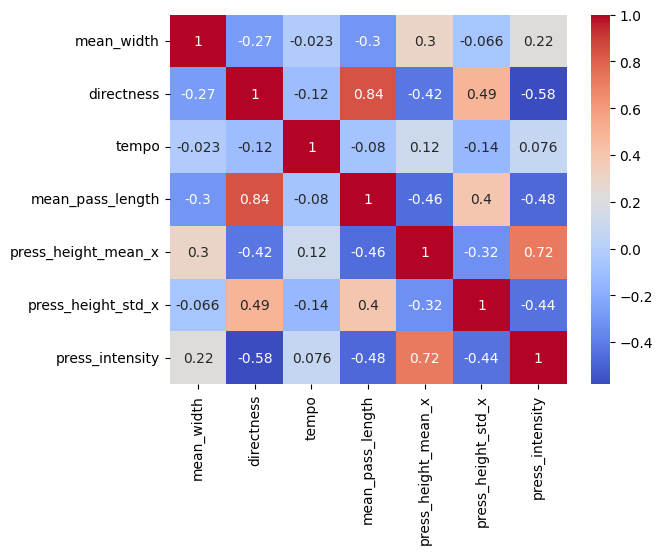

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(X.corr(), annot=True, cmap="coolwarm")
plt.show()


In [27]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4, random_state=42)
team_season_z["cluster"] = kmeans.fit_predict(X)
team_season_z.groupby("cluster")[cluster_cols].mean()


,mean_width,directness,tempo,mean_pass_length,press_height_mean_x,press_height_std_x,press_intensity
cluster,,,,,,,
0,1.377434,-0.601316,-0.179380,-0.170709,1.202141,-0.213114,1.289553
1,0.087021,-0.959972,0.774240,-1.089370,0.442388,-0.615340,0.398698
2,-0.259325,0.450793,-0.738829,0.366867,-0.509393,0.289703,-0.403342
3,-1.160252,1.753320,1.271080,1.873270,-0.838107,0.862029,-1.315386


In [28]:
for c in sorted(team_season_z["cluster"].unique()):
    print(f"\nCluster {c}")
    print(team_season_z.loc[team_season_z["cluster"] == c, "team_name"].values)




Cluster 0
['AFC Bournemouth' 'Tottenham Hotspur' 'Manchester United']

Cluster 1
['Arsenal' 'Liverpool' 'Swansea City' 'Chelsea' 'Manchester City'
 'Aston Villa']

Cluster 2
['Leicester City' 'Watford' 'Southampton' 'Everton' 'Stoke City'
 'Crystal Palace' 'Newcastle United' 'West Ham United' 'Norwich City']

Cluster 3
['West Bromwich Albion' 'Sunderland']


In [24]:
cluster_cols = [
    "mean_width",
    "directness",
    "tempo",
    "mean_pass_length",
    "std_pass_length",
    "press_height_mean_x",
    "press_height_std_x",
    "press_intensity",
]

cluster_summary = team_season_z.groupby("cluster")[cluster_cols].mean()
cluster_summary


,mean_width,directness,tempo,mean_pass_length,std_pass_length,press_height_mean_x,press_height_std_x,press_intensity
cluster,,,,,,,,
0,1.377434,-0.601316,-0.179380,-0.170709,-0.494605,1.202141,-0.213114,1.289553
1,0.087021,-0.959972,0.774240,-1.089370,-1.079181,0.442388,-0.615340,0.398698
2,-0.259325,0.450793,-0.738829,0.366867,0.559672,-0.509393,0.289703,-0.403342
3,-1.160252,1.753320,1.271080,1.873270,1.460928,-0.838107,0.862029,-1.315386


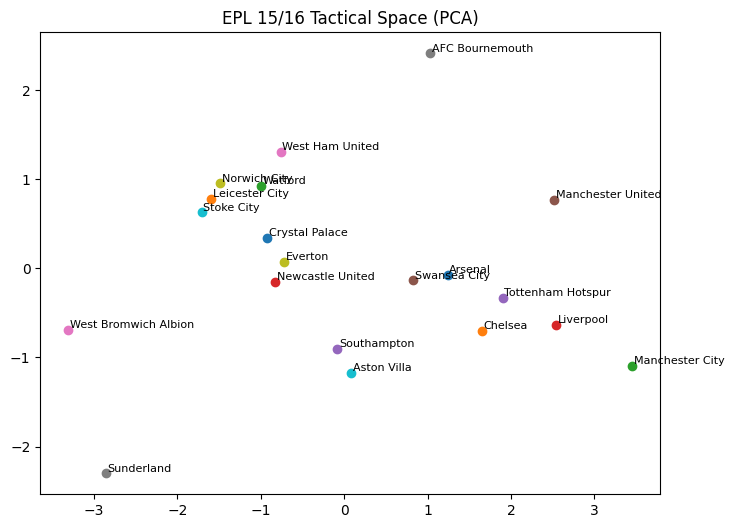

In [29]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
X_2d = pca.fit_transform(X)

plt.figure(figsize=(8,6))
for i, team in enumerate(team_season_z["team_name"]):
    plt.scatter(X_2d[i,0], X_2d[i,1])
    plt.text(X_2d[i,0]+0.02, X_2d[i,1]+0.02, team, fontsize=8)

plt.title("EPL 15/16 Tactical Space (PCA)")
plt.show()
